In [6]:
#ONLY PRACTICE CODE-----------------------------------------------------------------------
import cv2
import numpy as np
import os
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL
import tensorflow as tf
import os
import math
import easyocr
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
from IPython.display import display
import io
from PIL import Image

In [2]:
# ------------------------------ CHANGES WITHIN THE CODE DENOTED BY DASHES

In [3]:
#im = Image.open(i)
#im.save('new1.png')
IMAGE_PATH = "images.png"
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1" #ALGO

In [4]:
def preprocess_image(image_path):
  
  hr_image = tf.image.decode_image(tf.io.read_file(image_path)) #Image is decoded and its datatype and number of channels can be changed
  
  if hr_image.shape[-1] == 3:  #.REDUCING CHANNELS CAN VARY RESULTS FOR DIFF IMAGES
    #hr_image = hr_image[...,:-1]   #REDUCING CHANNELS CODE IS COMMENTED OUT-------------------------
    hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4   #convert to tensor
    hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1]) #limit image to a box
    hr_image = tf.cast(hr_image, tf.float32)
    return tf.expand_dims(hr_image, 0)

def save_image(image, filename):
  
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)   #limit colors min and max value
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())  #cast meaning converting to int format
  image.save("%s.png" % filename)   #CHANGED FILE FORMAT TO PNG-------------------
  print("Saved as %s.png" % filename)

In [5]:
%matplotlib inline
def plot_image(image, title=""):
  
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title('TITLE')

In [6]:
hr_image = preprocess_image(IMAGE_PATH)

Saved as Original Image.png


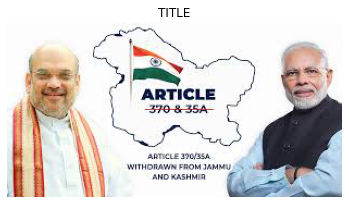

In [7]:
plot_image(tf.squeeze(hr_image), title="Original Image")
save_image(tf.squeeze(hr_image), filename="Original Image")

In [8]:
model = hub.load(SAVED_MODEL_PATH)   #ALGORITHM

In [9]:
fake_image = model(hr_image)           #ALGORITHM
fake_image = tf.squeeze(fake_image)

Saved as Super Resolution.png


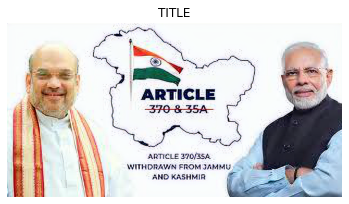

In [10]:
plot_image(tf.squeeze(fake_image), title="Super Resolution")
save_image(tf.squeeze(fake_image), filename="Super Resolution") #squeeze eliminates all the values within the tensor with magnitude 1

In [11]:
import pytesseract as tess
import cv2
import PIL
import easyocr

In [12]:
#SUPERRESOLUTION IMAGE
img = cv2.imread('/home/mes-am/upyter/Super Resolution.png')  #(h,w,channels) : (640,1232,3)  
#ROI IMAGE
img_cropped = img[100:300,400:800]   #roi = img[y1:y2,x1:x2]
#ROI IMAGE being SAVED IN (Super resolution text roi.png)
cv2.imwrite('/home/mes-am/upyter/Super Resolution text roi.png',img_cropped)

True

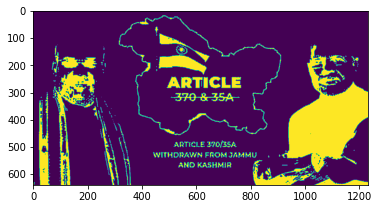

In [10]:
img = cv2.imread('/home/mes-am/upyter/Super Resolution.png')
grayimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_,th1 = cv2.threshold(grayimg,150,255,cv2.THRESH_TOZERO)
_,th2 = cv2.threshold(th1,0,255,cv2.THRESH_BINARY_INV)
blur = cv2.GaussianBlur(th2,(5,5),0)
_,th4 = cv2.threshold(blur,127,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(th4)

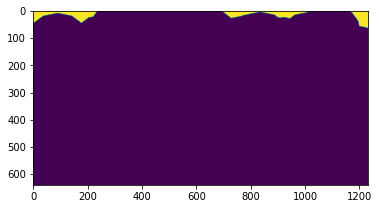

In [36]:
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(th1,cv2.MORPH_OPEN,kernel, iterations = 2)

# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
plt.imshow(sure_fg)

In [20]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

True

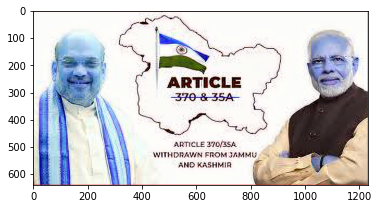

In [31]:
markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]
plt.imshow(img)
cv2.imwrite('/home/mes-am/upyter/Super Resolution text roi watershed.png',img)

In [45]:
v = cv2.imread('/home/mes-am/upyter/Super Resolution text roi watershed.png',0)  #640 1232

In [30]:
reader = easyocr.Reader(['en']) 
result = reader.readtext('/home/mes-am/upyter/Super Resolution text roi watershed.png',detail=0)
print(result)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


['ARTICLE', '40 & 35A', 'RRTICLE 37054', 'WVITHDRAVIN FROMJAMMU', 'AND KASHMIR']
